In [7]:
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

# Problem 1  
Compare the conditional distribution of the Multivariate Normal, to the OLS equations. Are  
these values the same? Why?  
Use the data in problem1.csv to prove your answer empirically.

## Answer
Suppose there are two variables x and y. We can either deem x and y as jointly bivariate normal, or use x to explain y based on OLS. Under both cases, y is a normally distributed variable given x as a condition. Denote these distributions as $N(\mu_1, \sigma_1)$ and $N(\mu_2, \sigma_2)$.  
We can calculate the unbiased estimator of $E(y|x)$ and $Var(y|x)$ as parameters of y's distribution under these two cases and compare their difference.

### Case 1. Conditional Distribution of the Multivariate Normal
We assume that the (x, y) datapoints in problem1.csv are independent variables under the same biviarate normal distribution. 
The conditional distribution of y given knowledge of x is a normal distribution $N(\mu, \sigma)$ with:  
$$\mu = \mu_{y} + \frac{\sigma_{xy}}{\sigma^{2}_{x}}(x - \mu_{x})$$
$$\sigma = \sigma_{y} - \frac{\sigma^{2}_{xy}}{\sigma_{x}}$$
where $\mu_{y}$, $\mu_{x}$ are mean value of y and x, $\sigma_{y}$, $\sigma_{x}$, $\sigma_{xy}$ are variance of y and x and covariance between them.

First, we need to calculate $E(x)$, $E(y)$, and the covariance matrix. This can be done by calling APIs of Pandas. 

In [2]:
data1 = pd.read_csv("problem1.csv").sort_values('x')

# mean
mean = data1.mean()
mean_x, mean_y = mean.loc['x'], mean.loc['y'] 
print(f"\mu_1 = {mean_x}, \mu_2 = {mean_y}\n")

# covariance
print("Covariance Matrix of x, y:")
cov = data1.cov()
print(cov)
var_x, var_y, cov_xy = cov.loc['x', 'x'], cov.loc['y', 'y'], cov.loc['x', 'y']

\mu_1 = -0.14054562796809722, \mu_2 = -0.0222771880352644

Covariance Matrix of x, y:
          x         y
x  1.315195  0.562908
y  0.562908  0.898883


We want to make sure that the variance estimator provided by pandas is unbiased. That is to say, the sum of squared deviation is divided by n-1 but not n.

In [3]:
n = len(data1.x)
my_var_x = np.square(data1.x - np.mean(data1.x)).sum() / (n-1)
var_x_unbiased = math.isclose(my_var_x, var_x, rel_tol=0.000001)
if var_x_unbiased:
    print("Var(x) provided by Pandas is unbiased.")
else:
    print("Var(x) provided by Pandas is biased.")

Var(x) provided by Pandas is unbiased.


Then we define functions that calculate $\mu$ and $\sigma$.

In [4]:
def conditional_mean(x2, mu1, mu2, var2, cov12):
    """
    calculate conditional mean of x1 given the knowldge of x2, 
    if x1 and x2 follow a bivariate normal distribution.
    
    params:
        - x2
        - mu1: mean of x1
        - m2: mean of x2.
        - var2: variance of x2
        - cov12: covariance of x1 and x2
    """
    return mu1 + cov12 / var2 * (x2 - mu2)

def conditional_var(var1, var2, cov12):
    """
    calculate conditional variance of x1 given the knowldge of x2, 
    if x1 and x2 follow a bivariate normal distribution.
    
    params:
        - var1: variance of x1
        - var2: variance of x2
        - cov12: covariance of x1 and x2
    """
    return var1 - cov12**2 / var2

cond_mean_y = conditional_mean(data1.x, mean_y, mean_x, var_x, cov_xy)
cond_var_y = conditional_var(var_y, var_x, cov_xy)

### Case2. OLS
We assume that $$y_{i} = \beta_{0} + \beta_{1}x_{i} + \epsilon_{i}$$
and all assumptions of OLS are satisfied.
Then the unbiased estimator for $\mu_2$ is $\hat{\beta}_0 + \hat{\beta}_1x$. Since $Var(y|x) = Var(\beta_1x + \epsilon|x)=Var(\epsilon)$, the unbiased estimator for $\sigma_2$ is $\frac{SSR}{n - 2}$.

In [5]:
# fit the data by ols and calculate y's mean and variance given x
results1 = sm.OLS(data1.y, sm.add_constant(data1.x)).fit()
ols_mean_y = results1.fittedvalues
ols_var_y = results1.ssr / results1.df_resid

### Conclusion  
We can draw y's conditional mean calculated in case1 and y's OLS fitted value on the same plot.   
These two lines overlap each other, which means $\mu_1 = \mu_2$. Here is a mathematical proof:

The estimator of $\beta$ is 
$$\hat{\beta} = (X'X)^{-1}X'Y$$

where $X =[ \begin{matrix} 1 & x \end{matrix}] = \left[ \begin{matrix} 1 & x_1 \\ 1 & x_2\\ ...&... \\ 1 & x_n \end{matrix} \right]$,  $Y = y = \left[ \begin{matrix} y_1 \\ y_2\\ ... \\ y_n \end{matrix} \right]$, and  $\beta =[ \begin{matrix} \beta_0 & \beta_1 \end{matrix}]$, therefore 

$$
\begin{aligned}
& \hat{\beta_0} = \frac{1}{n}\sum^{n}_{i=1}{y_i}\\
& \hat{\beta_1} = \frac{\frac{1}{n-1}\sum^{n}_{i=1}{(x_i - \bar{x})(y_i - \bar{y})}}{\frac{1}{n-1}\sum^{n}_{i=1}{(x_i - \bar{x})^2}}
\end{aligned}
$$

We notice that $\frac{1}{n-1}\sum^{n}_{i=1}{(x_i - \bar{x})(y_i - \bar{y})}$ is the unbiased estimator of $\sigma_{xy}$, and $\frac{1}{n-1}\sum^{n}_{i=1}{(x_i - \bar{x})^2}$ is the unbiased estimator of $\sigma_x$. 


By rewriting
$$\hat{y} = \hat\beta_0 + \hat{\beta_1}x $$

as
$$\hat{y} - \bar{y} = \hat{\beta_0} + \hat{\beta_1}x - (\hat{\beta_0} + \hat{\beta_1}\bar{x})$$
we come up with 
$$\hat{y} = \bar{y} + \hat{\beta_1}(x - \bar{x})$$

which is the same as the formula of y's conditional mean in case 1
$$\mu = \mu_{y} + \frac{\hat{\sigma_{xy}}}{\hat{\sigma^{2}_{x}}}(x - \mu_{x})$$


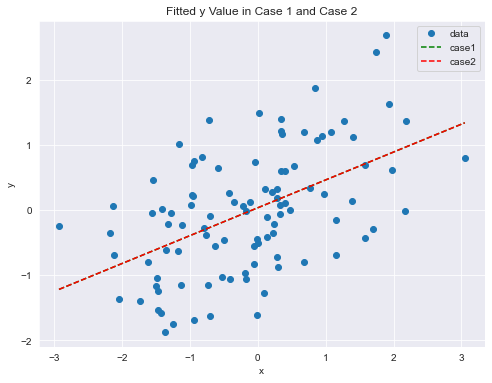

In [6]:
# plot fitted y value 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data1.x, data1.y, 'o', label="data")
ax.plot(data1.x, cond_mean_y, 'g--', label="case1")
ax.plot(data1.x, results1.fittedvalues, 'r--', label="case2")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Fitted y Value in Case 1 and Case 2")
ax.legend(loc='best')

However $\sigma_1$ is different from $\sigma_2$.

In [7]:
print(f"\sigma_1 = {cond_var_y}, \sigma_2 = {ols_var_y}") 

\sigma_1 = 0.6579563030192093, \sigma_2 = 0.6646701428459357


# Problem 2
Fit the data in problem2.csv using OLS and calculate the error vector. Look at it’s distribution.  
How well does it fit the assumption of normally distributed errors?  
Fit the data using MLE given the assumption of normality. Then fit the MLE using the assumption of a T distribution of the errors. Which is the best fit?  
What are the fitted parameters of each and how do they compare? What does this tell us about the breaking of the normality assumption in regards to expected values in this case?

In [8]:
import scipy.stats as stats
import scipy.optimize as optimize

## Answer

We assume that $$y_{i} = b_{0} + b_{1}x_{i} + \epsilon_{i}$$
and all assumptions of OLS are satisfied, then fit the data in problem2.csv using OLS and calculate the error vector.  
The summary shows that the estimated value for $b_0$ and $b_1$ is 0.1198 and 0.6052.

In [9]:
# fit the data using ols
data2 = pd.read_csv("problem2.csv").sort_values('x')
results = sm.OLS(data2.y, sm.add_constant(data2.x)).fit()
results.summary()

# caculate the error vector
error = data2.y - results.fittedvalues

### 1. Are errors normally distributed?  
The errors are supposed to be normally distributed, whose the mean value is 0 and variance can be estimated by $\frac{SSR}{n-2}$.  
We use these parameters to generate a series of random normal variables and compare its distribution to that of the errors.  
It seems that the error vector has more values in [0, 1] than it should.  
We can also draw the quantile-quantile plot for the errors. If they are normally distributed, the points on the plot will form a line that's roughly straight. In this case, I think it's not.

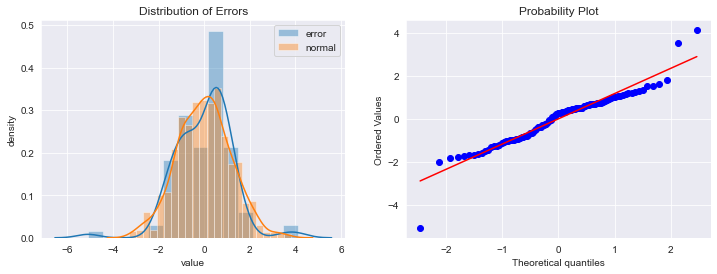

In [10]:
# generate a normal variable witht the same mean = 0 and variance = SSR / (n-2).
sigma = np.sqrt(results.ssr / results.df_resid)
normal_dist = np.random.normal(loc=0.0, scale=sigma, size=1000)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# plot error and the random normal's density on the subplot0
pic0 = sns.distplot(error, ax=axes[0], label="error")
pic0 = sns.distplot(normal_dist, ax=axes[0], label="normal")
axes[0].set_title("Distribution of Errors")
axes[0].set_xlabel("value")
axes[0].set_ylabel("density")
axes[0].legend()

# draw qq plot on subplot1
pic1 = stats.probplot(error, dist=stats.norm, plot=axes[1])

In addition, we can use the Shapiro-Wilks method to examine whether errors are normally distributed.  
The test suggests that we should reject the hypothesis that errors are normally distributed. 

In [11]:
# Shapiro-Wilk test
print("Null Hypothesis: errors are normally distributed.")
alpha = 0.05
test_stat, p = stats.shapiro(error)
print(f"w-test statistic = {test_stat}, pvalue = {p}")

if p < alpha:
    print("Hypothesis rejected. Errors are probably not normally distributed.")
else:
    print("Hypothesis not rejected. Errors are probably normally distributed.")

Null Hypothesis: errors are normally distributed.
w-test statistic = 0.9383853077888489, pvalue = 0.00015388526662718505
Hypothesis rejected. Errors are probably not normally distributed.


### 2. Fit the data using MLE  
In case1,we fit the data under the assumption of normality, then fit the data under the assumption of t distribution of errors in case2.  
They generated different results for parameters (in case 1, the results are the same as that produced by OLS).    
SSE in case 1 is still lower than that in case2. However, The AIC and BIC are higher.  
The differences indicates that breaking of the normality assumption will result in different estimated values of parameters and thus a   difference in the expected value of y.  

In [12]:
class RegressionMLEstimator:
    """
    An abstract class to estimate b0, b1 in regression
        
        y = b0 + b1*x + e
    
    using the MLE method.
    
    The distribution of e is not determined. 
    Users should define the distribution of e in subclasses. 
    """
    
    def __init__(self, y, x):
        self.y = y
        self.x = x
        self.n = len(y)  # data size 
        
        self.result = None
        
    def residual(self, b0, b1):
        return self.y - b0 - b1*self.x
    
    @staticmethod
    def ll(dist, x):
        """
        The log likelihood function.
        
        params:
            - dist: distribution of x, a callable object provided by scipy.stats
            - x: the random variable that follows dist 
        """
        return np.log(dist.pdf(x)).sum()
    
    def error_dist(*args):
        """
        The distribution of e, which is to be determined.
        The args users pass in this method will be used as additional parameters to be estimated in MLE. 
        Therefore there will be len(args) + 2 parameters to be estimated.
        """
        raise NotImplementedError
    
    def estimate(self, **kwargs):
        """Estimate the parameters by maximizing log likelihood function."""
        
        # customize the log-likelihood function and negate it
        def negated_ll(args):
            """
            The negated log likelihood function, so that minimizing it achieves 
            the same effect as maximizing the log likelihood function.
            
            args[0], args[1] represents b0 and b1 and are used to generate the error vector
            args[2:] are passed to self.error_dist to generate the distribution of errors
            """
            dist = self.error_dist(*args[2:])
            e = self.residual(*args[:2])
            return -self.ll(dist, e)
        
        self.result = optimize.minimize(negated_ll, **kwargs)
    
    @property
    def b0(self):
        """Estimated value of b0."""
        return self.result.x[0]
    
    @property
    def b1(self):
        """Estimated value of b1."""
        return self.result.x[1]
    
    def sse(self):
        """Caluluate the sum of squared errors"""
        rsd = self.residual(self.b0, self.b1)
        return np.square(rsd).sum()
    
    def fitted_y(self):
        return self.b0 + self.b1 * self.x 
    
    def max_ll(self):
        """The maximum of log likelihood function."""
        return -self.result.fun
    
    def aic(self):
        k = len(self.result.x) # the number of parameters estimated by MLE
        return 2*k - 2*self.max_ll()
    
    def bic(self):
        k = len(self.result.x) # the number of parameters estimated by MLE
        return k*np.log(self.n) - 2*self.max_ll()
    
    def report(self):
        print(f"b0 = {self.b0}, b1 = {self.b1}")
        print(f"SSE = {self.sse()}")
        print(f"AIC = {self.aic()}")
        print(f"BIC = {self.bic()}")
    
    
class NormalEstimator(RegressionMLEstimator):
    """
    Estimate b0, b1 in regression
        
        y = b0 + b1*x + e
    
    using the MLE method, where e is normally distributed.
    """
    
    def error_dist(self, sigma):
        """Assume error follows N(0, sigma)"""
        return stats.norm(0, sigma)
    
    
class TEstimator(RegressionMLEstimator):
    """
    Estimate b0, b1 in regression
        
        y = b0 + b1*x + e
    
    using the MLE method, where e follows a t distribution.
    """
    
    def error_dist(self, df, scale):
        """
        Assume error follows a T distribution 
        whose degree of freedom is df and is scaled by scale.
        """
        return stats.t(df=df, scale=scale)
    
    
norm_estimator = NormalEstimator(data2.y, data2.x)
norm_estimator.estimate(x0=(0, 1, 1),  # initial values of b0, b1 and sigma
                        constraints=({"type":"ineq", "fun":lambda x: x[2]})) # sigma, the 2nd parameter, should be positive
                                                                             # "fun" represents a boundary for the optimization
                                                                             # by always returing a positive value in each iteration
        
        
t_estimator = TEstimator(data2.y, data2.x)
t_estimator.estimate(x0=(0, 1, len(data2.y)-2, 1), # initial values of b0, b1, df and scale
                     constraints=({"type":"ineq", "fun":lambda x: x[2]}, # the degree of freedom of t distribution is positive 
                                  {"type":"ineq", "fun":lambda x: int(x[3]!=0)}))# scale, the 3rd parameter, should not be zero
                                                                                 # which means int(x[3] != 0) == 1 > 0    



By comparing SSE, AIC, and BIC, we find the t-distribution assumption generates a better fit.

In [7]:
print(f"If errors follow a normal distribution, then")
norm_estimator.report()
print('\n')
print(f"If errors follow a t distribution, then")
t_estimator.report()

If errors follow a normal distribution, then
b0 = 0.1198446690635319, b1 = 0.6051913741196576
SSE = 143.6148485649267
AIC = 325.9841938565872
BIC = 333.79970441455146


If errors follow a t distribution, then
b0 = 0.14261176176518411, b1 = 0.5575637173275871
SSE = 143.88182394009263
AIC = 318.9459412475349
BIC = 329.36662199148725


A different assumption in errors distribution results in different fitted values.

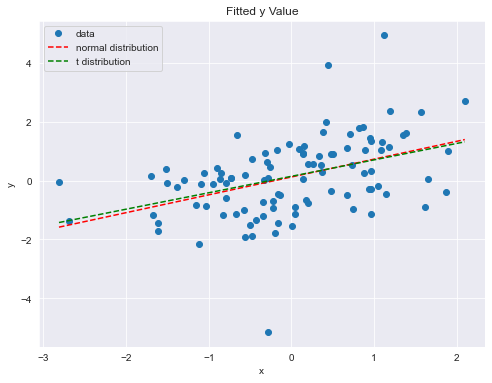

In [14]:
# plot the fitted y values
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data2.x, data2.y, 'o', label="data")
ax.plot(data2.x, norm_estimator.fitted_y(), 'r--', label="normal distribution")
ax.plot(data2.x, t_estimator.fitted_y(), 'g--', label="t distribution")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Fitted y Value")
ax.legend(loc='best')

# Problem 3
Simulate AR(1) through AR(3) and MA(1) through MA(3) processes. Compare their ACF and  
PACF graphs. How do the graphs help us to identify the type and order of each process?

In [15]:
from functools import partial
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [16]:
def simulate_ARMA_process(ar, ma, nsample=300):
    """Simulate an ARMA process."""
    ARMA_object = ArmaProcess(ar=[1] + [coef * -1 for coef in ar],
                              ma=[1] + ma)
    simulated_data = ARMA_object.generate_sample(nsample=nsample)
    return simulated_data


simulate_AR_process = partial(simulate_ARMA_process, ma=[])
simulate_MA_process = partial(simulate_ARMA_process, ar=[])   


def plot_processes(processes, titles, save=False):
    """
    Plot the processes, their lag-0 to lag-30 ACF and 
    PACF with a confidence level of 0.05. 
    """
    n_prcs = len(processes)
    fig, axes = plt.subplots(n_prcs, 3, figsize=(5*n_prcs,3*n_prcs))
    
    alpha = 0.05
    lags = 30
    
    for i, process in enumerate(processes):
        
        axes[i][0].plot(process)
        plot_acf(process, alpha=alpha, lags=lags, ax=axes[i][1])
        plot_pacf(process, alpha=alpha, lags=lags, ax=axes[i][2])
        
        # plot labels and titles
        axes[i][0].set_ylabel(ylabel=titles[i],labelpad=0.6,loc='center')
        if i == 0:
            axes[i][0].set_title('data')
            axes[i][1].set_title('ACF')
            axes[i][2].set_title('PACF')
        else:
            axes[i][0].set_title('')
            axes[i][1].set_title('')
            axes[i][2].set_title('')
    if save:
        fig.savefig(f'{"_".join(titles)}_processes.png')

## Answer
### 1. AR Processes
We simulate AR processes
$$
\begin{aligned}
&y_t = 0.3y_{t-1} + \epsilon_t \\
&y_t = 0.3y_{t-1} + 0.3y_{t-2} + \epsilon_t\\     
&y_t = 0.3y_{t-1} + 0.3y_{t-2} + 0.3y_{t-3} + \epsilon_t\\   
\end{aligned}
$$
and plot their ACF and PACF.  
We can discover that for the AR(1) process, only the lag-1 PACF is significantly different from 0; for the AR(2) process, lag-1 and lag-2 PACF is significantly different from 0; for the AR(3) process, lag-1, lag-2 and lag-3 PACF is significantly different from 0. However, there is no obvious pattern with ACFs.   
(lag-0 ACFs and PACFs are not considered since they are always 1.)

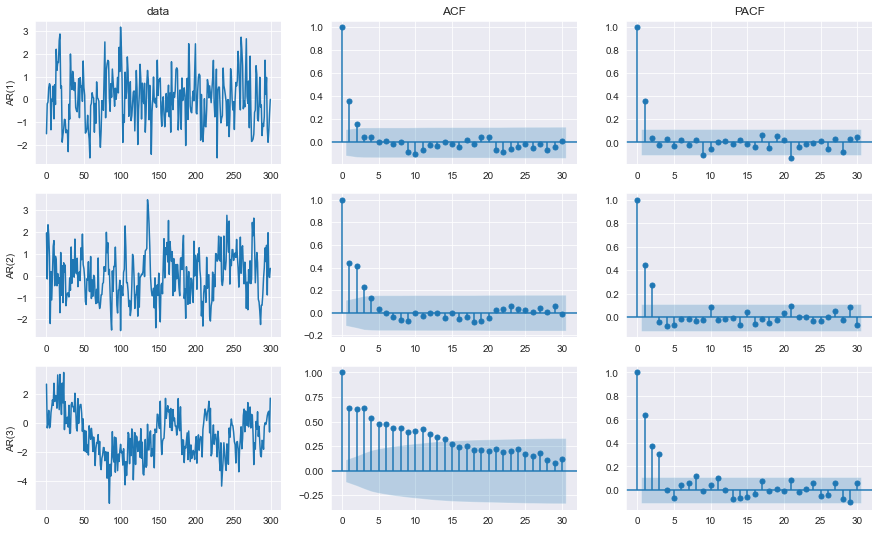

In [17]:
ar_list = [[0.3], [0.3]*2, [0.3]*3]
ar_processes = [simulate_AR_process(ar=ar_coeffs) for ar_coeffs in ar_list]
pic = plot_processes(ar_processes, ['AR(1)', 'AR(2)', 'AR(3)'], False)

### 2. MA Processes
Then we simulate MA processes
$$
\begin{aligned}
&y_t = \epsilon_{t} + 0.3\epsilon_{t-1} \\
&y_t = \epsilon_{t} + 0.3\epsilon_{t-1} + 0.3\epsilon_{t-2} \\     
&y_t = \epsilon_{t} + 0.3\epsilon_{t-1} + 0.3\epsilon_{t-2}+ 0.3\epsilon_{t-3} \\   
\end{aligned}
$$
and plot their ACF and PACF.  
We can discover that for the MA(1) process, only the lag-1 ACF is significantly different from 0; for the MA(2) process, lag-1 and lag-2 ACF is significantly different from 0; for the MA(3) process, lag-1, lag-2 and lag-3 ACF is significantly different from 0. 

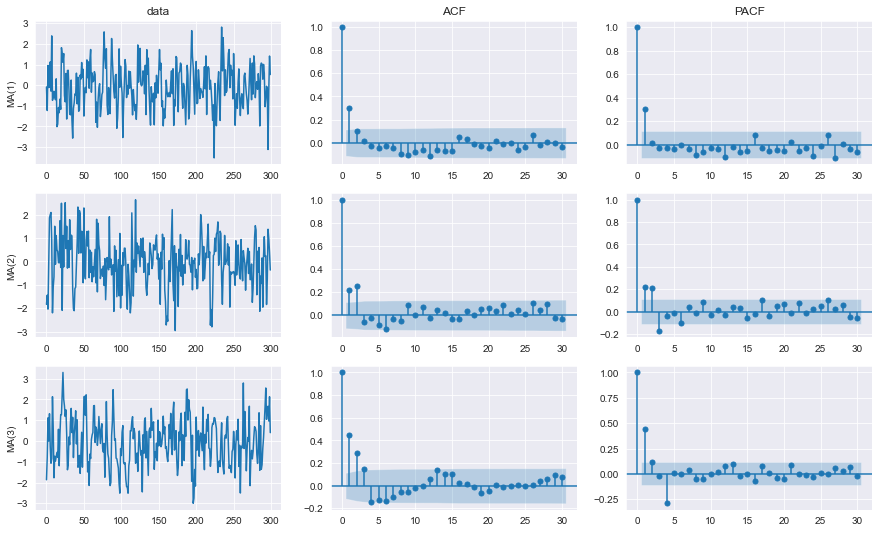

In [18]:
ma_list = [[0.3], [0.3]*2, [0.3]*3]
ma_processes = [simulate_MA_process(ma=ma_coeffs) for ma_coeffs in ma_list]
plot_processes(ma_processes, ['MA(1)', 'MA(2)', 'MA(3)'], False)

### 3. Identifying type and order
As a result, we can use ACF graphs and PACF graphs to identify the type and order of each process by observing the number of lags they remain significant.  
For example, if we find that only lag-1 to lag-4 PACF of a process is significantly different from 0,but the ACF remains significant for a large number of lags,  we may consider it to be an AR(4).
For another, if we find that only lag-1 to lag-3 ACF of a process is significantly different from 0, but no obvious pattern in PACF, we
may think it to be a MA(3).